In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import os

In [2]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [29]:
DATA_DIR = os.path.join(os.getcwd(), '../data/safety/total_df.csv')

# Not using the columns formed by IsolationForest
cols = ['acceleration_mean', 'acceleration_median', 'acceleration_std',
       'acceleration_spread', 'gyro_pc_mean', 'gyro_pc_median', 'gyro_pc_std',
       'gyro_pc_spread', 'speed_mean', 'speed_median', 'speed_std',
       'speed_spread', 'second_mean', 'second_median', 'second_std',
       'second_spread', 'over_speed', 'over_second', 'over_acceleration_x',
       'over_acceleration_y', 'over_acceleration_z', 'over_gyro_x',
       'over_gyro_y', 'over_gyro_z', 'label']


agg_diff_df = pd.read_csv(DATA_DIR)
agg_diff_df = agg_diff_df.drop('bookingid', axis='columns')
agg_diff_df = agg_diff_df[cols]
agg_diff_df.head(n=10)

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_spread,over_speed,over_second,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z,label
0,9.883337,9.852269,0.619492,6.530989,-0.006583,-0.002863,0.099002,1.101352,9.003204,8.503366,...,1589.0,247,687,709,1002,801,570,581,614,0
1,9.865608,9.847932,0.522142,5.819621,-0.006855,-0.003612,0.090770,1.123587,8.019369,7.206634,...,1034.0,157,168,483,270,790,230,404,347,1
2,9.929590,9.877755,0.515173,5.168422,-0.012751,0.001369,0.117109,0.896289,3.157213,2.998761,...,825.0,0,0,102,143,34,67,103,71,1
3,9.813434,9.791035,0.620066,13.349284,0.022429,0.024239,0.112628,1.166471,6.150996,3.310000,...,1094.0,122,232,389,1094,1072,531,735,753,1
4,9.918090,9.904142,0.585346,7.280114,0.000480,0.004189,0.106469,1.161481,4.628921,1.936962,...,1094.0,18,232,463,407,257,533,450,561,0
5,9.826470,9.789800,0.916836,8.572037,0.002651,-0.002687,0.072664,0.903745,12.176386,13.017325,...,959.0,365,97,809,262,219,561,490,687,0
6,9.763213,9.646309,0.730155,9.416841,-0.000840,0.000250,0.078446,0.754180,5.384260,3.540000,...,462.0,25,0,357,94,36,157,159,82,0
7,9.550677,9.494390,0.833292,9.474737,0.001922,-0.000612,0.110181,0.909695,8.702027,9.580000,...,374.0,90,0,300,71,307,90,111,149,0
8,9.948639,9.877962,0.750480,5.686104,-0.004018,-0.003111,0.151980,0.988519,6.659024,5.192059,...,299.0,14,0,129,120,44,147,154,141,0
9,9.873517,9.823053,0.425662,5.916028,-0.002192,0.000388,0.082987,0.767631,4.152211,3.702154,...,555.0,1,0,155,441,10,349,207,374,0


### Downsampling

Downsample to ensure that the neural network learns to classify equally, and not focusing on one class etc \
Train set will have 50:50 distribution, test set will follow actual distribution of 75:25

In [ ]:
# dist = agg_diff_df['label'].value_counts()
# actual_dist = dist[1] / (dist[0] + dist[1]) 
# actual_dist # About 25%

In [52]:
# Downsampling training set to get equal class distribution
seed = 199

np.random.seed(seed)

count_0 = agg_diff_df['label'].value_counts()[0]
count_1 = agg_diff_df['label'].value_counts()[1]

idx0 = agg_diff_df[agg_diff_df['label'] == 0].index.values
sample_0_idx = np.random.choice(idx0, count_1)

df_0 = agg_diff_df.iloc[sample_0_idx, :]
downsample_df = pd.concat([df_0, agg_diff_df[agg_diff_df['label'] == 1]]).sample(frac=1).reset_index(drop=True)

X = downsample_df.drop('label', axis=1)
y = downsample_df['label']

X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

In [53]:
# Reforming test set to have class distribution of 75% class 0 : 25% class 1
prop = count_1 / (count_0 + count_1)
sample_0_idx2 = [idx for idx in idx0 if idx not in sample_0_idx]

y_count = y_test2.value_counts()[1]
sample_0_idx2 = np.random.choice(sample_0_idx2, size=np.int((y_count / 25) * 75))

new_df0 = agg_diff_df.iloc[sample_0_idx2, :].sample(n=np.int((y_count / 25) * 75))
test = pd.merge(X_test2, y_test2, left_index=True, right_index=True)
test = test[test['label'] == 1]

df_merge = pd.concat([new_df0, test], axis=0).reset_index(drop=True).sample(frac=1)

X_test, y_test = df_merge.drop('label', axis=1), df_merge['label']

In [54]:
# Checking distributions
print("Training class distribution : ")
print(y_train.value_counts())

print("Testing class distribution : ")
print(y_test.value_counts())

Training class distribution : 
1    3999
0    3940
Name: label, dtype: int64
Testing class distribution : 
0    2889
1     963
Name: label, dtype: int64


### Non-downsampling approach

Leaving distribution as is then see how it goes...

In [ ]:
# seed = 13

# np.random.seed(seed)

# X = agg_diff_df.drop('label', axis=1)
# y = agg_diff_df['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     random_state=seed, shuffle=True)

# print(y_train.value_counts())
# print(y_test.value_counts())

### Standardising data to have mean = 0 and standard deviation = 1

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train_scaled.describe()

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_std,second_spread,over_speed,over_second,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z
count,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,...,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03
mean,-1.117997e-15,-3.582131e-16,-5.544822e-17,-1.301040e-16,2.805362e-17,-5.848874e-18,-5.993023e-17,-6.174121e-18,3.027906e-16,6.368504e-17,...,6.267817e-17,3.945005e-17,3.052099e-16,-1.153295e-16,-7.215086e-17,-9.555554e-17,5.628729e-19,-2.121436e-17,-3.736637e-17,3.382831e-17
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-1.403143e+01,-1.487927e+01,-1.263256e+00,-1.265030e+00,-7.505363e+01,-7.457329e+01,-6.390963e-01,-4.769338e-01,-1.987609e+00,-1.409070e+00,...,-1.882765e+00,-1.878490e+00,-8.315435e-01,-6.904687e-01,-1.390601e+00,-1.040193e+00,-1.041998e+00,-1.375954e+00,-1.479895e+00,-1.468457e+00
25%,-1.389243e-01,-1.059107e-01,-4.052873e-01,-4.342546e-01,-2.422009e-02,-8.605665e-03,-2.943770e-01,-2.756335e-01,-7.383328e-01,-7.663352e-01,...,-7.227561e-01,-7.502336e-01,-7.705905e-01,-6.904687e-01,-7.157829e-01,-7.651875e-01,-7.877953e-01,-7.601378e-01,-7.377072e-01,-7.365042e-01
50%,-1.701149e-02,1.429840e-02,-1.874991e-01,-1.923706e-01,9.958785e-04,-1.561686e-03,-1.994687e-01,-2.314391e-01,-2.150629e-01,-2.388728e-01,...,-1.233851e-01,-1.365864e-01,-4.211267e-01,-5.378694e-01,-2.365645e-01,-2.858195e-01,-3.617028e-01,-2.458660e-01,-2.347075e-01,-2.380789e-01
75%,1.127595e-01,1.334502e-01,9.040556e-02,1.231454e-01,2.565321e-02,7.447437e-03,-7.748910e-02,-1.606479e-01,6.101081e-01,6.079683e-01,...,6.032076e-01,6.188211e-01,4.687871e-01,4.709818e-01,4.578130e-01,4.761233e-01,5.631116e-01,5.239039e-01,5.145158e-01,4.834178e-01
max,4.721768e+01,4.991402e+01,1.586540e+01,1.694057e+01,3.429427e+01,3.467825e+01,2.857527e+01,1.822551e+01,4.312907e+00,3.527370e+00,...,1.412638e+01,1.407828e+01,7.584033e+00,1.840423e+01,1.095172e+01,9.059334e+00,7.392697e+00,9.544952e+00,1.041974e+01,1.077607e+01


In [56]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test_scaled.describe()

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_std,second_spread,over_speed,over_second,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z
count,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,...,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03
mean,-5.931926e-17,-9.702851e-16,2.048127e-16,-1.195032e-17,-1.862621e-17,1.458393e-17,-1.572663e-16,6.953305e-18,-2.386893e-16,-1.102081e-16,...,-2.556510e-17,-1.317165e-16,-3.620042e-17,4.621318e-16,-8.983814e-17,5.029437e-17,-8.473665e-18,3.686332e-17,-4.487584e-17,-1.354057e-16
std,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,...,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00
min,-9.517856e+00,-9.678875e+00,-1.406150e+00,-1.379592e+00,-1.043166e+01,-9.735176e+00,-7.270629e-01,-4.629994e-01,-1.865650e+00,-1.395112e+00,...,-1.854968e+00,-1.842653e+00,-8.195180e-01,-6.477713e-01,-1.372258e+00,-1.045952e+00,-1.009899e+00,-1.359921e+00,-1.443346e+00,-1.455797e+00
25%,-9.932039e-02,-7.957876e-02,-4.246305e-01,-4.625899e-01,-3.243065e-01,-1.786610e-01,-3.213616e-01,-2.587445e-01,-7.470991e-01,-7.792574e-01,...,-7.427452e-01,-7.444038e-01,-7.628744e-01,-6.477713e-01,-7.187891e-01,-7.627491e-01,-7.761838e-01,-7.824426e-01,-7.551285e-01,-7.572613e-01
50%,-1.508900e-02,-2.272165e-03,-1.587854e-01,-1.717348e-01,-1.138947e-02,-5.136919e-02,-1.958964e-01,-2.089942e-01,-2.424808e-01,-2.662417e-01,...,-1.370580e-01,-1.459317e-01,-4.230129e-01,-6.477713e-01,-2.435390e-01,-2.986110e-01,-3.519392e-01,-2.501882e-01,-2.501863e-01,-2.467564e-01
75%,6.830606e-02,7.102765e-02,1.681711e-01,1.762076e-01,2.882491e-01,1.208569e-01,-2.988886e-02,-1.315703e-01,5.971829e-01,6.360827e-01,...,6.472530e-01,6.609556e-01,4.428247e-01,4.364485e-01,4.527373e-01,4.775747e-01,5.022658e-01,5.473237e-01,5.427599e-01,5.410946e-01
max,3.184967e+01,3.233498e+01,1.769901e+01,1.528644e+01,1.382471e+01,1.179318e+01,1.604057e+01,2.192246e+01,3.946116e+00,3.199149e+00,...,6.607630e+00,6.626252e+00,5.548839e+00,9.282254e+00,9.722735e+00,6.631993e+00,6.382626e+00,5.392404e+00,5.764236e+00,6.291091e+00


### Function to build model

Writing a function here so that the Keras sklearn wrapper can be used for the GridSearchCV (last section)

In [57]:
def build_model(num_layers=1, num_nodes=32, lr=0.001, dropout=False, opt="SGD", input_shape=(24,)):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))
    
    if dropout:
        model.add(Dropout(rate=0.5))
    
    if num_layers > 1:
        for i in range(num_layers - 1):
            model.add(Dense(num_nodes, activation='relu'))
            if dropout:
                model.add(Dropout(rate=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if opt == "SGD":
        optimiser = optimizers.SGD(lr=lr)
    elif opt == "RMSprop":
        optimiser = optimizers.RMSprop(lr=lr)
    elif opt == "Adam":
        optimiser = optimizers.Adam(lr=lr)
    
    model.compile(loss="binary_crossentropy", 
               optimizer=optimiser,
               metrics=["accuracy"])
            
    return model

### K-fold cross validation of train data

In [58]:
import datetime
start_time = datetime.datetime.now()

k = 5
num_val_samples = X_train_scaled.shape[0] // k
num_epochs = 60
batch_size = 32
all_val_loss = []
all_train_loss = []
all_val_acc = []
all_train_acc = []

for i in range(k):
    print('Processing fold {} of {}'.format(i + 1, k))

    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], 
                                         X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], 
                                            y_train[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model(num_layers=2, num_nodes=64, lr=0.001, opt="SGD", dropout=True, input_shape=((24,)))
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, verbose=0,
                        validation_data=((val_data, val_targets)), batch_size=batch_size)

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    all_val_loss.append(val_loss)
    all_train_loss.append(loss)
    all_val_acc.append(val_acc)
    all_train_acc.append(acc)

    end_time = datetime.datetime.now()
    print("Total time taken: {} seconds".format((end_time - start_time).seconds))

Processing fold 1 of 5
Total time taken: 51 seconds
Processing fold 2 of 5
Total time taken: 106 seconds
Processing fold 3 of 5
Total time taken: 164 seconds
Processing fold 4 of 5
Total time taken: 221 seconds
Processing fold 5 of 5
Total time taken: 280 seconds


Train loss: 0.6389220841585539, train acc: 0.6245906949043274
Val loss: 0.6165098827818165, val acc: 0.6482671618461608


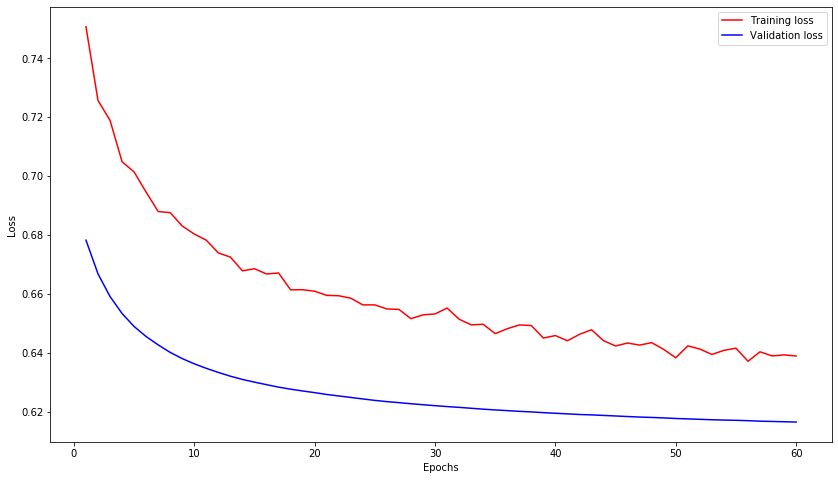

In [59]:
average_val_loss = [np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]
average_train_loss = [np.mean([x[i] for x in all_train_loss]) for i in range(num_epochs)]

average_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
average_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

print("Train loss: {}, train acc: {}".format(average_train_loss[-1], average_train_acc[-1]))
print("Val loss: {}, val acc: {}".format(average_val_loss[-1], average_val_acc[-1]))

plt.figure(figsize=(14,8))
plt.plot(range(1, len(average_train_loss) + 1), average_train_loss, color="r", label="Training loss")
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, color="b", label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Performing predictions after getting a satisfactory model

In [61]:
model = build_model(num_layers=2, num_nodes=64, lr=0.001, opt="SGD", dropout=True, input_shape=((24,)))
history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

res = model.predict(X_test_scaled)
res = [round(num[0]) for num in res]

roc_auc_score(y_test, res)

Epoch 1/60
7939/7939 [==============================] - 2s 192us/step - loss: 0.7502 - accuracy: 0.5216
Epoch 2/60
7939/7939 [==============================] - 1s 117us/step - loss: 0.7325 - accuracy: 0.5300
Epoch 3/60
7939/7939 [==============================] - 1s 119us/step - loss: 0.7226 - accuracy: 0.5414
Epoch 4/60
7939/7939 [==============================] - 1s 117us/step - loss: 0.7221 - accuracy: 0.5405
Epoch 5/60
7939/7939 [==============================] - 1s 119us/step - loss: 0.7028 - accuracy: 0.5570
Epoch 6/60
7939/7939 [==============================] - 1s 116us/step - loss: 0.6982 - accuracy: 0.5572
Epoch 7/60
7939/7939 [==============================] - 1s 117us/step - loss: 0.6922 - accuracy: 0.5732
Epoch 8/60
7939/7939 [==============================] - 1s 117us/step - loss: 0.6849 - accuracy: 0.5770
Epoch 9/60
7939/7939 [==============================] - 1s 117us/step - loss: 0.6824 - accuracy: 0.5808
Epoch 10/60
7939/7939 [==============================] - 1s 118u

0.6498788508134302

### Randomised grid search 

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_params)

params = {'num_nodes' : [32, 64, 128, 256],
         'num_layers' : [1, 2], 
         'lr' : [0.0001, 0.001, 0.01, 0.1],
         'dropout' : [True, False],
         'opt' : ['SGD', "RMSprop", "Adam"]}

model = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32)
# grid = GridSearchCV(model, param_grid=params, n_jobs=4, cv=5)
# grid.fit(X_train, y_train)

seed = 299
num_iter = 5

random_grid = RandomizedSearchCV(estimator=model, 
                                 param_distributions=params, 
                                 scoring='roc_auc', n_iter=num_iter, cv=5, n_jobs=-1,
                                 random_state=seed)
random_grid.fit(X_train_scaled, y_train)

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
7939/7939 [==============================] - 4s 469us/step - loss: 0.6427 - accuracy: 0.6274
Epoch 2/20
7939/7939 [==============================] - 3s 342us/step - loss: 0.6228 - accuracy: 0.6430
Epoch 3/20
7939/7939 [==============================] - 3s 354us/step - loss: 0.6144 - accuracy: 0.6487
Epoch 4/20
7939/7939 [==============================] - 3s 359us/step - loss: 0.6139 - accuracy: 0.6455
Epoch 5/20
7939/7939 [==============================] - 3s 362us/step - loss: 0.6107 - accuracy: 0.6507
Epoch 6/20
7939/7939 [==============================] - 3s 359us/step - loss: 0.6082 - accuracy: 0.6551
Epoch 7/20
7939/7939 [==============================] - 3s 402us/step - loss: 0.6050 - accuracy: 0.6556
Epoch 8/20
7939/7939 [==============================] - 3s 408us/step - loss: 0.6078 - accuracy: 0.6574
Epoch 9/20
7939/7939 [==============================] - 3s 401us/step - loss: 0.6055 - accuracy: 0.6618
Epoch 10/20
7939/7939 [==============================] - 3s 379u

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a430e7110>,
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'dropout': [True, False],
                                        'lr': [0.0001, 0.001, 0.01, 0.1],
                                        'num_layers': [1, 2],
                                        'num_nodes': [32, 64, 128, 256],
                                        'opt': ['SGD', 'RMSprop', 'Adam']},
                   pre_dispatch='2*n_jobs', random_state=299, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [26]:
print(random_grid.best_score_)
print(random_grid.best_params_)

0.7289189711320792
{'opt': 'Adam', 'num_nodes': 128, 'num_layers': 2, 'lr': 0.001, 'dropout': True}
